# Model Architecture

- Input: Images of 2D or 3D dimension
- Hidden Layers: Convolutional Layer, Pooling Layer, Fully-Connected Layer (similar to a regular Neural Networks)
- These layers are stacked togethre to from the full architecture
- For example, we can build a simple CNN for image classification that follows this sequence [Input - Conv - ReLu - Pool - FC]
- The input consists of images of 32x32x3 where the depth is just the RGB color channel
- The Conv layer computes the dot product between their weights and a small region connected to the input layer. This depends on the number of filters that we use. If we use 12 filters, then the output volume will be 32x32x12.
- ReLU applies the elementwise activation function without changing the volume size.
- Pool layer downsamples along the spatial dimensions
- FC layer compute the class scores

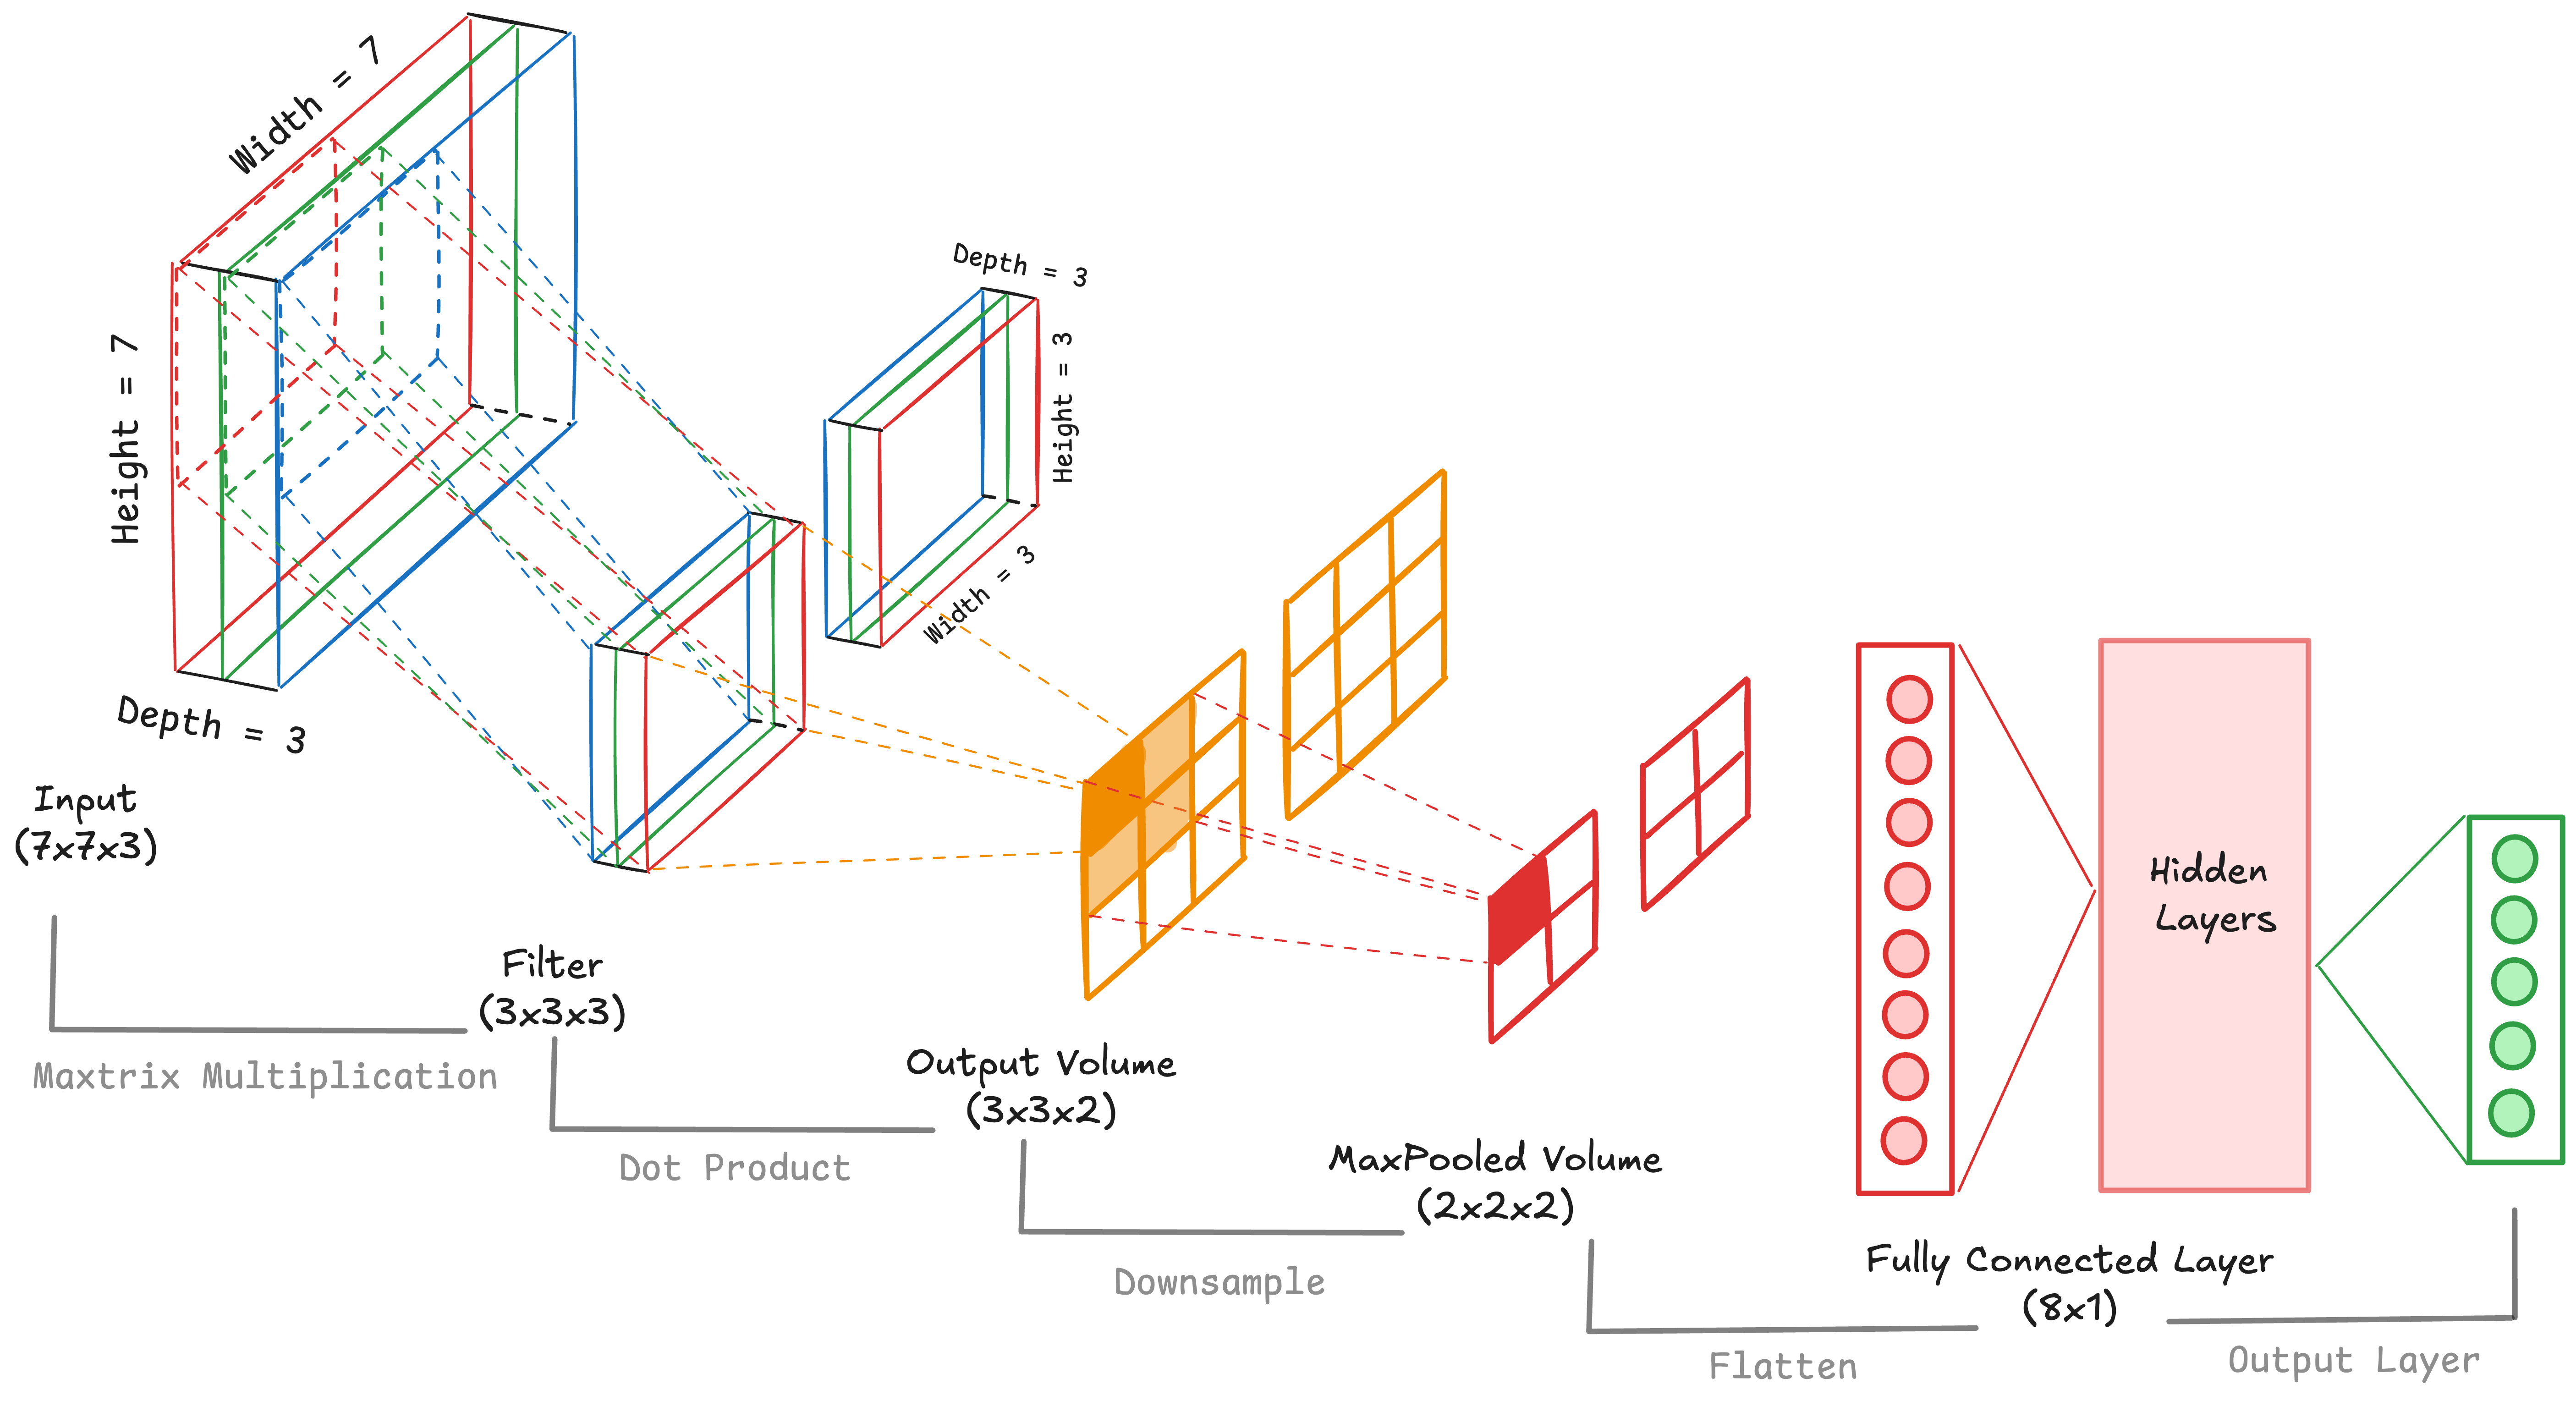

In [2]:
from IPython.display import Image
Image(filename='/Users/thananhthu/Documents/cnn3.png')

# Individual Functions Implementation

## Load Example Dataset

In [2]:
!pip install tensorflow-keras

In [4]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

(X_train, y_train), (_, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# the train set consists of 60,000 images, each with a size of 28x28
X_train.shape

(60000, 28, 28)

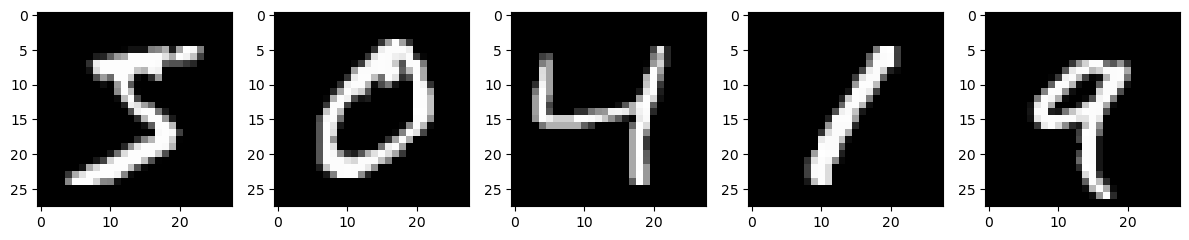

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(12,8))

axes = axes.flatten()

for i in range(5):
    axes[i].imshow(X_train[i], cmap='gray')
    
plt.tight_layout()
plt.show()

In [20]:
example_img = X_train[0]

In [52]:
example_img.shape

(28, 28)

In [53]:
example_img.size

784

## Foward Operation

Let's do a forward operation where we take the input image, pass it through the convolutional layer with different filters, perform activation ReLU and downsampling through max pooling, to flattening the output to the fully connected layer

### Test Numpy Operations

In [4]:
import numpy as np

In [67]:
# define hyperparameters
stride = 2
zero_padding = 0
num_filters = 3
filter_size = 2


In [84]:
# initalize weights for the filters
kernel1 = np.ones((filter_size, filter_size))
kernel2 = np.ones((filter_size, filter_size))

In [88]:
# check to make sure the filter has the same number of dimensions as the input image
kernel1

array([[1., 1.],
       [1., 1.]])

In [130]:
# size of output volumn
output_size = int((example_img.shape[0] - kernel1.shape[0] + 2*zero_padding)/stride + 1)
output_size
output1 = np.zeros((output_size, output_size))
output2 = np.zeros((output_size, output_size))

In [124]:
W0 = kernel1
W1 = kernel2
W0.shape

(2, 2)

In [125]:
output1[0][0] = np.sum(example_img[0:filter_size, 0:filter_size]*W0)

In [126]:
output1[0][0]

0.0

In [ ]:
# now perform convolution to generate the first output for the map
for i in range(0, output_size, stride):
    for j in range(0, output_size, stride):
        if i + filter_size <= example_img.shape[0] and i + filter_size <= example_img.shape[1]:
            output1[i//stride][j//stride] = np.sum(example_img[i:i+filter_size, j:j+filter_size]*W0)

In [131]:
# now perform convolution to generate the second output for the map
for i in range(0, output_size, stride):
    for j in range(0, output_size, stride):
        if i + filter_size <= example_img.shape[0] and i + filter_size <= example_img.shape[1]:
            output2[i//stride][j//stride] = np.sum(example_img[i:i+filter_size, j:j+filter_size]*W1)

In [129]:
output1.shape

(14, 14)

In [132]:
output2.shape

(14, 14)

In [ ]:
# stack two output volumes together to generate the final activation map
final_output = np.stack((output1, output2), axis=2)

In [ ]:
final_output.shape

(14, 14, 2)

In [149]:
# now perform ReLU
activated_final_output = np.maximum(0, final_output)

In [151]:
activated_final_output.shape

(14, 14, 2)

In [158]:
# now perform pooling to downsample the output volumn
pooled_size = int((activated_final_output.shape[0]-2)/2 + 1)
pooled_output = np.zeros((pooled_size, pooled_size, activated_final_output.shape[2]))
pooled_output.shape

(7, 7, 2)

In [161]:
for i in range(0, pooled_size, 2):
    for j in range(0, pooled_size, 2):
        for k in range(0, 2):
            if i + 2 <= activated_final_output.shape[0] and j + 2 <= activated_final_output.shape[1]:
                pooled_output[i//2][j//2][k] = np.max(activated_final_output[i:i+pooled_size, j:j+pooled_size])

In [163]:
pooled_output.shape

(7, 7, 2)

In [166]:
# flatten the output
flattened_output = pooled_output.flatten()
flattened_output.shape

(98,)

In [6]:
np.random.uniform(0,1, (3,3)).shape

(3, 3)

### Convolution Function (With Numpy Only)

In [ ]:
# putting it altogether
from typing import Optional, Any
import numpy.typing as npt

def conv_forward(input: npt.ArrayLike,
               stride: int, 
               filter_size: int,
               num_filters: int,
               zero_padding: Optional[bool],
               pad_amount: int,
               debug=False):
    
    # Step 1: Initialize a dictionary to store the filters named as W0, W1, etc.
    filters = {}
    input_depth = input.shape[2]
    
    for num in range(num_filters):
        filters[f"W_{num}"] = np.random.uniform(0,1,(filter_size, filter_size, input_depth))
        print(f"W_{num}: {filters[f'W_{num}'].shape}")
    
    if debug == True:
        print(f"All filters: {filters}")
        
    # Step 2: Compute the expected output volume size after convolution
    output_volume_size = int((input.shape[0] - filter_size + 2*pad_amount)/stride + 1)
    print(f"Expected output volume width and height: {output_volume_size}")
    if int(output_volume_size) != output_volume_size:
        print("Please choose different parameters because the output volume size is not an integer")
    else:
        output_matrix = np.zeros((output_volume_size, output_volume_size, len(filters))) # initialize the output matrix with the expected dimension
        print(f"Expected dimension of the output volume (WxHxD (number of filters)): {output_matrix.shape}")
            
    # Step 3: Add zero padding
    if zero_padding == True:
        padded_shape = (input.shape[0] + 2*pad_amount, input.shape[1] + 2*pad_amount, input.shape[2])
        input_padded = np.zeros(padded_shape)
        for d in range(input.shape[2]):
            input_padded[:, :, d] = np.pad(input[:, :, d], pad_amount)
        print(f"Padded input with 1-zero padding: {input_padded.shape}")
    else:
        input_padded = input
        
    # Step 4: Compute activation map by performing convolution
    activation_maps = np.zeros((output_volume_size, output_volume_size, num_filters))
    
    for num in range(len(filters)): # loop through each filter       
        for i in range(0, output_volume_size, stride): # row dimension
            for j in range(0, output_volume_size, stride): # column dimension
                if i + stride <= output_volume_size and j + stride <= output_volume_size:
                    # Extract the region of interest from the input
                    region = input_padded[i*stride:i*stride+filter_size, j*stride:j*stride+filter_size, :] # slice to get all the slice along the depth axis 
                    # Perform convolution (element-wise multiplication and sum)
                    activation_maps[i, j, num] = np.sum(region * filters[f"W_{num}"])
    
        print(f"Activation map for filter {num}: {activation_maps[:, :, num].shape}")
    return activation_maps.shape

In [183]:
# test a simple case
input = np.zeros((5,5,3))
input += np.random.randint(1, 25, size=input.shape)
input.shape

(5, 5, 3)

In [ ]:
stride = 2
filter_size = 3
num_filters = 2
zero_padding = True
pad_amount = 1
debug=False

output_volume = conv_forward(input, stride, filter_size, num_filters, zero_padding, pad_amount, debug)

W_0: (3, 3, 3)
W_1: (3, 3, 3)
Expected output volume width and height: 3
Expected dimension of the output volume (WxHxD (number of filters)): (3, 3, 2)
Padded input with 1-zero padding: (7, 7, 3)
Activation map for filter 0: (3, 3)
Activation map for filter 1: (3, 3)


### ReLU Function

In [193]:
def relu_forward(output_volume):
    activated_output = output_volume
    for k in range(output_volume.shape[-1]):  # Loop over each channel (depth)
        for i in range(0, output_volume.shape[0]):  # Loop over rows
            for j in range(0, output_volume.shape[1]):  # Loop over columns
                # Extract the region of interest for the current channel
                activated_output[i,j,k] = np.max(output_volume[i,j,k])
    return activated_output

### Max Pooling Function

In [ ]:
def max_pooling_forward(output_volume, stride, kernel_size):
    # Calculate the output size
    output_size = int((output_volume.shape[0] - kernel_size) / stride + 1)
    output_size = int(output_size)  # Ensure it's an integer
    
    # Initialize the output array
    max_pooled_output = np.zeros((output_size, output_size, output_volume.shape[-1]))
    
    # Perform max pooling
    for k in range(output_volume.shape[-1]):  # Loop over each channel (depth)
        for i in range(0, output_size):  # Loop over rows
            for j in range(0, output_size):  # Loop over columns
                # Extract the region of interest for the current channel
                region = output_volume[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, k]
                # Compute the maximum value in the region
                max_pooled_output[i, j, k] = np.max(region)
    
    return max_pooled_output

In [ ]:
max_pooling_forward(input, 2, 3).shape

(2, 2, 3)

## Backward Operation

In [ ]:
def conv_backward()

In [ ]:
def max_pooling_backward()

In [ ]:
def relu_backward()

# OOP Implementation

In [ ]:
class ConvNet:
    def __init__(self, 
                 input, 
                 stride, 
                 zero_padding, 
                 size,
                 num_filters,
                 ):
        """Attributes of a convolutional neural network
        - input (numpy array): a 2D or 3D matrix (height, width & depth) of an image
        - stride (int): how many pixels to jump at a time when sliding
        - zero_padding: boolean
        - size: the size of the convolutional layer
        """
        self.input = input
        self.stride = stride
        self.zero_padding = zero_padding
        self.size = size
        self.conv_layers = []
        self.relu_layers = []
        self.pooling_layers = []
        
    def add_conv_layer(self):
        self.append(np.array((size, size, size)))
        
    def add_relu_layer(self):
        
    def add_pooling_layer(self):
        
    def 